In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [8]:
# Load dataset
file_path = 'filtered_weather_data.csv'  # Thay đổi đường dẫn của bạn
weather_data = pd.read_csv(file_path)
# Convert date column to datetime and set as index
weather_data['dt_iso'] = pd.to_datetime(weather_data['dt_iso'])
weather_data.set_index('dt_iso', inplace=True)

In [14]:
# Resample to daily data and fill missing values
daily_temp = weather_data['temp'].resample('D').mean().ffill()

# Ensure daily_temp has DatetimeIndex
daily_temp = daily_temp.to_frame()  # Convert to DataFrame if it's still a Series
daily_temp.index = pd.to_datetime(daily_temp.index)  # Convert index to DatetimeIndex

# Create lag features for Random Forest (e.g., temp of previous 7 days)
for lag in range(1, 8):
    daily_temp[f'temp_lag_{lag}'] = daily_temp['temp'].shift(lag)

# Drop rows with NaN values due to lagging
daily_temp = daily_temp.dropna()

# Add additional time-based features
daily_temp['day_of_week'] = daily_temp.index.dayofweek
daily_temp['month'] = daily_temp.index.month


In [16]:
# Split data into features (X) and target (y)
X = daily_temp.drop('temp', axis=1)
y = daily_temp['temp']

# Split data into train and test sets (85% train, 15% test)
split_index = int(len(X) * 0.85)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [18]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

MAE: 0.5388796265650534
MSE: 0.5239118846677294
RMSE: 0.723817576926486


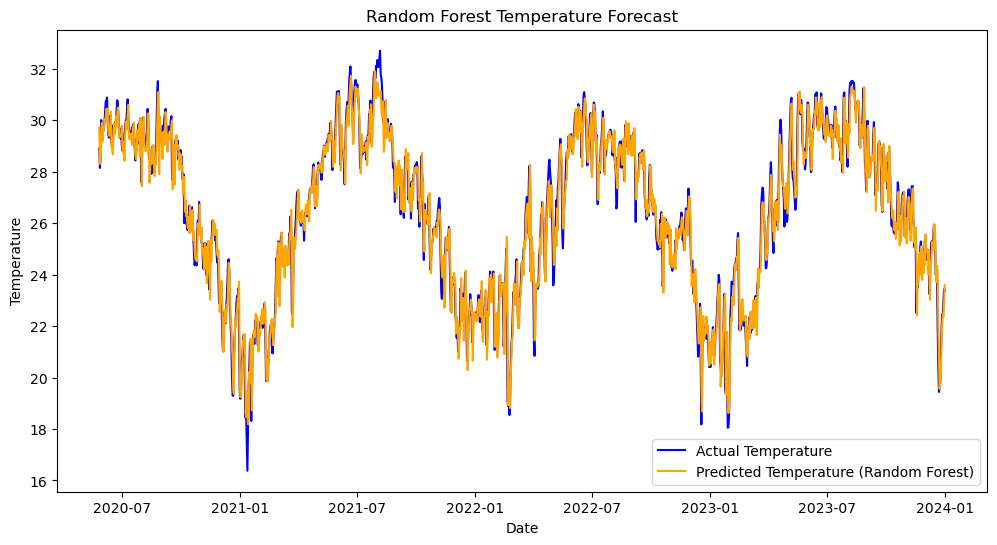

In [19]:
# Predict on the test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Temperature', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Temperature (Random Forest)', color='orange')
plt.title('Random Forest Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Mean Squared Error: 0.7859651768027422


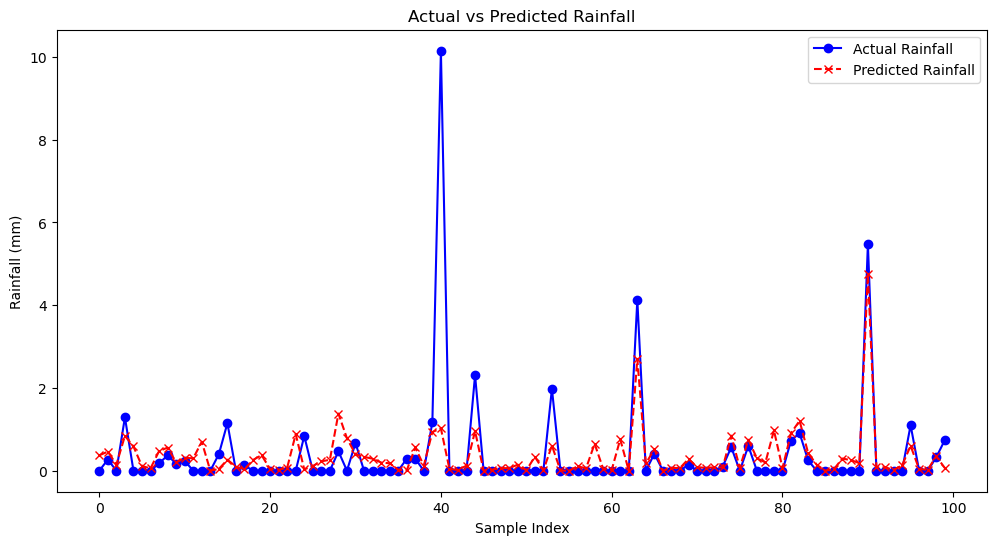

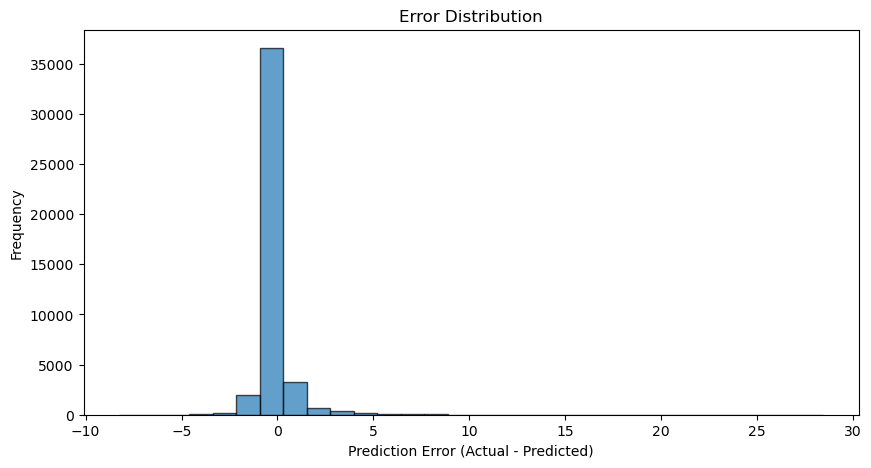

In [26]:


# Preprocessing: Fill NaN values in the rain_1h column with 0 (assuming no rain if not recorded)
weather_data['rain_1h'] = weather_data['rain_1h'].fillna(0)

# Selecting relevant features and the target
features = ['temp', 'visibility', 'dew_point', 'feels_like', 'pressure', 'humidity', 
            'wind_speed', 'wind_deg', 'clouds_all']
X = weather_data[features]
y = weather_data['rain_1h']

# Handling any remaining missing values in feature columns by imputing with mean values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the Random Forest model
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)  # Reduced number of trees to 50
rf_model.fit(X_train, y_train)

# Making predictions
y_pred = rf_model.predict(X_test)

# Calculating performance with Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Visualization 1: Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual Rainfall', color='blue', marker='o')
plt.plot(y_pred[:100], label='Predicted Rainfall', color='red', linestyle='--', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Rainfall (mm)')
plt.title('Actual vs Predicted Rainfall')
plt.legend()
plt.show()

# Visualization 2: Error Distribution
errors = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()